# Metadata

```
Course:   DS 5001
Module:   11 Lab
Topic:    Combine Lexicons
Author:   R.C. Alvarado

Purpose:  Collect all lexicons into a single database.
```

## Set Up

In [1]:
data_home = '../data'

# Get Data

In [2]:
bing_pos_file = f"{data_home}/salex/sources/opinion-lexicon-English/positive-words.txt"
bing_neg_file = f"{data_home}/salex/sources/opinion-lexicon-English/negative-words.txt"
nrc_file = f"{data_home}/salex/sources/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
syuzhet_file = f"{data_home}/salex/sources/Jockers/syuzhet.csv"
gi_file = f"{data_home}/salex/sources/general-inquirer/gi_sent_mean.csv"

In [3]:
import sqlite3
import pandas as pd
import re

# Import Bing lexicon

First, download RAR file from [here](http://sentiment.christopherpotts.net/lexicons.html#opinionlexicon).  Then open in a text editor and convert encoding and line endings in an editor.

In [4]:
bing_list = [(word.strip(), 'bing_positive', 1) 
             for word in open(bing_pos_file, 'r').readlines() 
             if re.match(r'^\w+$', word)]
bing_list += [(word.strip(), 'bing_negative', 1) 
              for word in open(bing_neg_file, 'r').readlines() 
              if re.match(r'^\w+$', word)]

In [5]:
bing = pd.DataFrame(bing_list, columns=['term_str', 'polarity', 'val'])
bing = bing.set_index(['term_str','polarity'])
bing = bing.unstack().fillna(0).astype('int')
bing.columns = bing.columns.droplevel(0)

In [6]:
bing.sum()

polarity
bing_negative    4659
bing_positive    1904
dtype: int64

## Create single sentiment column

In [7]:
bing['bing_sentiment'] = bing['bing_positive'] - bing['bing_negative']

In [8]:
bing.sample(10)

polarity,bing_negative,bing_positive,bing_sentiment
term_str,,,
enviously,1,1,0
embattled,1,0,-1
revive,0,1,1
cruelties,1,0,-1
ignominy,1,0,-1
examplary,0,1,1
thrilling,0,1,1
dud,1,0,-1
impassioned,0,1,1


# Import NRC lexicon

In [9]:
nrc = pd.read_csv(nrc_file, sep='\t', header=None)
nrc.columns = ['term_str','nrc_emotion','val']
nrc = nrc.set_index(['term_str','nrc_emotion'])
nrc = nrc.unstack()
nrc.columns = nrc.columns.droplevel(0)
nrc = nrc[nrc.sum(1) > 1]
nrc.columns = ['nrc_'+col for col in nrc.columns]

In [10]:
nrc.sum().sort_values(ascending=False)

nrc_negative        2366
nrc_fear            1368
nrc_positive        1281
nrc_anger           1208
nrc_sadness         1137
nrc_disgust         1004
nrc_trust            935
nrc_joy              686
nrc_anticipation     682
nrc_surprise         454
dtype: int64

In [11]:
nrc.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust
term_str,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0
abduction,0,0,0,1,0,1,0,1,1,0
aberration,0,0,1,0,0,1,0,0,0,0


## Compute Polarity

In [12]:
nrc['nrc_polarity'] = nrc.nrc_positive - nrc.nrc_negative

In [13]:
nrc

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,nrc_polarity
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


# Import Syuzhet lexicon

In [14]:
syu = pd.read_csv(syuzhet_file)
syu.columns = ['id','term_str','syu_sentiment']
syu = syu.drop('id', axis=1)
syu = syu.set_index('term_str')

In [15]:
syu.head()

,syu_sentiment
term_str,
abandon,-0.75
abandoned,-0.50
abandoner,-0.25
abandonment,-0.25
abandons,-1.00


# Import General Inquirer lexicon

This is prepared in a separate notebook.

In [16]:
gi = pd.read_csv(gi_file, index_col=['term_str'])
gi.columns = ['gi_sentiment']

In [17]:
gi.head()

,gi_sentiment
term_str,
abandon,-1
abandonment,-1
abate,-1
abdicate,-1
abhor,-1


## Import LabMT Salex

In [18]:
labmt_data = {}
labmt_features = "words scores".split()
for f in labmt_features:
    labmt_data[f] = open(f"{data_home}/salex/sources/labMT/labMT{f}-english.csv", 'r').readlines()
    labmt_data[f] = [x.strip() for x in labmt_data[f]]
    if 'scores' in f:
        labmt_data[f] = [float(x) for x in labmt_data[f]]
LABMT = pd.DataFrame(labmt_data).set_index('words')
LABMT.index.name = 'term_str'
LABMT.columns = ['labmt_happiness']

In [23]:
LABMT['labmt_z'] = ((LABMT.labmt_happiness - LABMT.labmt_happiness.mean()) / (LABMT.labmt_happiness.std()) - 1) 

# Combine all

In [24]:
combo = nrc.join(bing, how='outer')\
    .join(syu, how='outer')\
    .join(gi, how='outer')\
    .join(LABMT, how='outer')\
    .sort_index()

In [25]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,nrc_polarity,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment,labmt_happiness,labmt_z
term_str,,,,,,,,,,,,,,,,,,
#epicpetwars,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.54,-1.769874
#fact,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.30,-1.069351
#fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.62,-3.539615
#fb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.12,-1.235265
#ff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.64,-1.677700


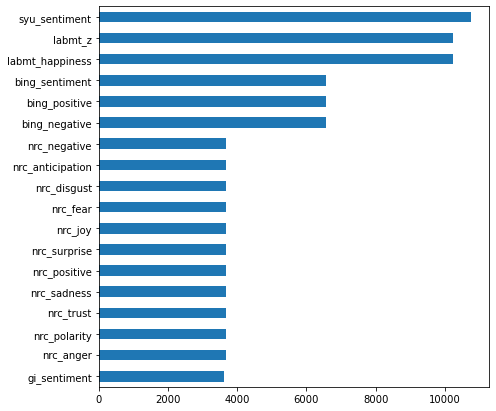

In [26]:
combo.count().sort_values().plot(kind='barh', figsize=(7,7));

# Save

In [27]:
nrc.to_csv(f'{data_home}/salex/salex_nrc.csv')
bing.to_csv(f'{data_home}/salex/salex_bing.csv')
syu.to_csv(f'{data_home}/salex/salex_syuzhet.csv')
gi.to_csv(f'{data_home}/salex/salex_gi.csv')
LABMT.to_csv(f'{data_home}/salex/salex_labmt.csv')
combo.to_csv(f'{data_home}/salex/salex_combo.csv')        